# COVID-19 Analysis

## High Level Dataset Review

The dataset is about the number of deaths in the US caused by COVID-19, pneumia, influenza, by different states, sex, and age groups. The data was reported by the CDC and collected by NCHS/DVS, which typically gathers such information through national health statistics, reporting systems, and other public health surveillance systems. The total size of the data frame is 85374 * 16. It is comprised of two separate datasets: 
- `cdc_death_counts_by_sex_age_state` : which breaks the weekly deaths down by age, sex, and state
- `cdc_death_counts_by_conditions` : which breaks the weekly deaths down by other reported conditions

The columns of : `cdc_death_counts_by_sex_age_state` <br>
<ul>
Data As of: The date of analysis of the report.<br>
Start Date: First date of data period.<br>
End Date: Last date of data period.<br>
Group: Indicator of whether data is measured by Month, by Year, or Total<br>
Year: Year in which death occured when data is grouped by year.<br>
Month: Month in which death occured when data is grouped by month.<br>
State: Jurisdiction of occurence. eg. The state where the data was collected from.<br>
</ul>

The columns of : `cdc_death_counts_by_conditions` <br>
<ul>
Data As of: The date of analysis of the report.<br>
Start Date: First date of data period.<br>
End Date: Last date of data period.<br>
Group: Indicator of whether data is measured by Month, by Year, or Total<br>
Year: Year in which death occured when data is grouped by year.<br>
State: Jurisdiction of occurence. eg. The state where the data was collected from.<br>
Month: Month in which death occured when data is grouped by month.<br>
Condition Group : This is a broad label for which, Condition, is a sub label.<br>
Condition : This is the specific label for the reported condition.<br>
ICD10_codes : These are specific codes for the conditions reported.<br>
Age Group : This is the age group for which the data is being reported.<br>
COVID-19 Deaths : This is the number of COVID-19 Deaths reported for the record.<br>
Number of Mentions : This represents the number of instances where the condition was cited on the death certificate.<br>
Flag : This is an indicator that <br>
</ul>


We're exploring data about number of deaths in the US caused by COVID-19, pneumia, influenza, by different states, sex, and age groups. The granularity of the data dependes on the specific (combination of the) columns. For example, a data row with columns of By Total, United States, All Sexes, All Ages indicates the total amount of COVID-19 Deaths in the united states from all states, all sexes, all ages groups, and the time frame is from the start of 2020, to 2022-3-19. While a data entry with By Month, California, Male, Under 1 year represents the number of data specific to that group of people during that specific time frame. The distribution of the data was explored, and majority of deaths are concentrated in people with older ages, and there are outliers. There are "missing" COVID-19 Deaths values, likely resulting from the way that the data set handles 0 values.

## Discussion of Potential Dataset Bias
Because these counts are based on coroner reports and other agregated data, the quality of the data set depends on the quality of the incoming dataset. If there were systematic issues with determining cause of death those would be reflected in the dataset. We are going to perform analysis on the data as reported, acknowledging the caveat above. 


## Initial Dataframe loading EDA

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder
import sklearn as sk
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, HuberRegressor, SGDRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
warnings.filterwarnings('ignore')

In [220]:
conditions = pd.read_csv(
    filepath_or_buffer= "data/cdc_death_counts_by_conditions.csv", 
    parse_dates=[0,1,2]
    )
display(conditions.head(5))
display(conditions.shape)

,Data As Of,Start Date,End Date,Group,Year,Month,State,Condition Group,Condition,ICD10_codes,Age Group,COVID-19 Deaths,Number of Mentions,Flag
0,2022-03-20,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,1277.0,1334.0,NaN
1,2022-03-20,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,5351.0,5551.0,NaN
2,2022-03-20,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,14089.0,14644.0,NaN
3,2022-03-20,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,35120.0,36444.0,NaN
4,2022-03-20,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,76708.0,79386.0,NaN


(385020, 14)

In [221]:
sas = pd.read_csv("data/cdc_death_counts_by_sex_age_state.csv", parse_dates = [0,1,2])
display(sas.shape)
display(sas.head(5))

(85374, 16)

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,2022-03-23,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,All Sexes,All Ages,974282.0,7520550.0,855731.0,504882.0,10684.0,1334231.0,NaN
1,2022-03-23,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,All Sexes,Under 1 year,242.0,41777.0,495.0,28.0,28.0,736.0,NaN
2,2022-03-23,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,All Sexes,0-17 years,933.0,74176.0,1460.0,252.0,204.0,2342.0,NaN
3,2022-03-23,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,All Sexes,1-4 years,113.0,7791.0,293.0,29.0,70.0,447.0,NaN
4,2022-03-23,2020-01-01,2022-03-19,By Total,NaN,NaN,United States,All Sexes,5-14 years,296.0,12438.0,424.0,96.0,82.0,705.0,NaN


## Investigating Column Values

In [222]:
print(conditions["Age Group"].unique())
print(sas["Age Group"].unique())

['0-24' '25-34' '35-44' '45-54' '55-64' '65-74' '75-84' '85+' 'Not stated'
 'All Ages']
['All Ages' 'Under 1 year' '0-17 years' '1-4 years' '5-14 years'
 '15-24 years' '18-29 years' '25-34 years' '30-39 years' '35-44 years'
 '40-49 years' '45-54 years' '50-64 years' '55-64 years' '65-74 years'
 '75-84 years' '85 years and over']


In both datasets, there are is `All Ages` in addition to all other ages. 

It looks like in `cdc_death_counts_by_conditions` there is a `Not stated` label 

It looks like in `cdc_death_counts_by_sex_age_state`  there are multiple overlapping age groups. 

We'll need to consider how to account for these features

In [223]:
display(conditions['Condition Group'].value_counts())


Condition Group
Circulatory diseases                                                         117180
Respiratory diseases                                                         100440
Sepsis                                                                        16740
Malignant neoplasms                                                           16740
Diabetes                                                                      16740
Obesity                                                                       16740
Alzheimer disease                                                             16740
Vascular and unspecified dementia                                             16740
Renal failure                                                                 16740
Intentional and unintentional injury, poisoning, and other adverse events     16740
All other conditions and causes (residual)                                    16740
COVID-19                                                    

In [224]:
display(conditions['Condition'].value_counts())

Condition
Influenza and pneumonia                                                      16740
Other diseases of the circulatory system                                     16740
All other conditions and causes (residual)                                   16740
Intentional and unintentional injury, poisoning, and other adverse events    16740
Renal failure                                                                16740
Vascular and unspecified dementia                                            16740
Alzheimer disease                                                            16740
Obesity                                                                      16740
Diabetes                                                                     16740
Malignant neoplasms                                                          16740
Sepsis                                                                       16740
Cerebrovascular diseases                                                     

In [225]:
print(conditions["Data As Of"].unique())
print(sas["Data As Of"].unique())

<DatetimeArray>
['2022-03-20 00:00:00']
Length: 1, dtype: datetime64[ns]
<DatetimeArray>
['2022-03-23 00:00:00']
Length: 1, dtype: datetime64[ns]


This column does not contain useful information for our analysis

In [226]:
print(conditions["Start Date"].unique().shape)
print(conditions["End Date"].unique().shape)
print(sas["Start Date"].unique().shape)
print(sas["End Date"].unique().shape)

(27,)
(27,)
(27,)
(27,)


It looks like we have 27 months of data in both tables

In [227]:
print(conditions["Flag"].unique())
print(sas["Footnote"].unique())

[nan
 'One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards.']
[nan
 'One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards.']


Some of the deaths have been censored, we'll have to consider that

In [228]:
print(conditions["State"].unique())
print(sas["State"].unique())

['United States' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California'
 'Colorado' 'Connecticut' 'Delaware' 'District of Columbia' 'Florida'
 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Hampshire' 'New Jersey' 'New Mexico' 'New York' 'New York City'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming'
 'Puerto Rico']
['United States' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California'
 'Colorado' 'Connecticut' 'Delaware' 'District of Columbia' 'Florida'
 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New

It looks like `United States` is represented along with all the other states... and PR and DC, and NYC and NY are reported separately

In [229]:
print(conditions["Group"].unique())
print(sas["Group"].unique())

['By Total' 'By Year' 'By Month']
['By Total' 'By Year' 'By Month']


We've got multiple levels of granularity here

In [230]:
print(conditions["Year"].unique())
print(conditions["Month"].unique())
print(sas["Year"].unique())
print(sas["Month"].unique())

[  nan 2020. 2021. 2022.]
[nan  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[  nan 2020. 2021. 2022.]
[nan  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


Nothing surprising here

In [231]:
print(sas["Sex"].unique())

['All Sexes' 'Male' 'Female']


It looks like there is an `All Sexes` label we'll need address

In [232]:
print(conditions["Age Group"].unique())

['0-24' '25-34' '35-44' '45-54' '55-64' '65-74' '75-84' '85+' 'Not stated'
 'All Ages']


Nonthing surpising here

In [233]:
print(sas["Age Group"].unique())

['All Ages' 'Under 1 year' '0-17 years' '1-4 years' '5-14 years'
 '15-24 years' '18-29 years' '25-34 years' '30-39 years' '35-44 years'
 '40-49 years' '45-54 years' '50-64 years' '55-64 years' '65-74 years'
 '75-84 years' '85 years and over']


Interestingly, it looks like there are ways of bracketing age, we'll have to make sure to only use one at at time

## Granularity Investigation
We will take a look at the granularity of these datasets in this section and make any modifications as necessary

In [234]:
display(conditions['Flag'].unique())
display(sas['Footnote'].unique())


array([nan,
       'One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards.'],
      dtype=object)

array([nan,
       'One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards.'],
      dtype=object)

It looks like some of the records will contain redacted information to protect privacy. We'll take a look at that soon

In [235]:
display(conditions['Group'].unique())
display(sas['Group'].unique())

array(['By Total', 'By Year', 'By Month'], dtype=object)

array(['By Total', 'By Year', 'By Month'], dtype=object)

It also looks like there are varying levels of temporal granularity. If we consider all of these records we would be double counting 

In [236]:
display(conditions[['Group']].value_counts())
display(sas[['Group']].value_counts())

Group   
By Month    335340
By Year      37260
By Total     12420
Name: count, dtype: int64

Group   
By Month    74358
By Year      8262
By Total     2754
Name: count, dtype: int64

The varying granularity of the `Group` column is resulting in double counting


In [237]:
display(conditions[['Group','COVID-19 Deaths']].groupby('Group').sum())
display(sas[['Group','COVID-19 Deaths']].groupby('Group').sum())

,COVID-19 Deaths
Group,
By Month,14448024.0
By Total,14769969.0
By Year,14747342.0


,COVID-19 Deaths
Group,
By Month,8740895.0
By Total,8804666.0
By Year,8800488.0


In addition to the varying temporal granularity double counting, it looks like there is a slight variation in the reported number of deaths for each level of granularity. 

This is explained earlier as the more granular the data, the more likely to drop below the threshold where the data is censored. 

We will remove all the "agregation" rows from all the datasets, using the highest resolution and finest granularity and then look at how much of the dataset is censored. 

In [238]:
display(conditions[['State','COVID-19 Deaths']].groupby(conditions['State'] == 'United States').sum(numeric_only=True))
display(sas[['State','COVID-19 Deaths']].groupby(sas['State'] == 'United States').sum(numeric_only=True))

,COVID-19 Deaths
State,
False,21837641.0
True,22127694.0


,COVID-19 Deaths
State,
False,13159321.0
True,13186728.0


It looks like there are double countings here as well

In [239]:
display(sas[['Sex','COVID-19 Deaths']].groupby('Sex').sum())

,COVID-19 Deaths
Sex,
All Sexes,13186446.0
Female,5763445.0
Male,7396158.0


Again we're double counting 

## Granularity Homogenization

Remove `By Year` `By Total` from `Group`

In [240]:
conditions = conditions[conditions['Group'] == 'By Month'] 
sas = sas[sas['Group'] == 'By Month'] 

Remove `United States` from `State`

In [241]:
conditions = conditions[conditions['State'] != 'United States'] 
sas = sas[sas['State'] != 'United States'] 

Remove `All Sexes` from `Sex` in `cdc_death_counts_by_sex_age_state`

In [242]:
sas = sas[sas['Sex'] != 'All Sexes']

Remove `All Ages` from `Age`

In [243]:
conditions = conditions[conditions['Age Group'] != 'All Ages'] 
sas = sas[sas['Age Group'] != 'All Ages'] 

In [244]:
display(conditions['COVID-19 Deaths'].sum())
display(sas['COVID-19 Deaths'].sum())

3403304.0

1183925.0

## Missing Values Analysis

In [245]:
sas[sas["COVID-19 Deaths"].isna()].head(3)

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
12422,2022-03-23,2020-01-01,2020-01-31,By Month,2020.0,1.0,Alabama,Male,50-64 years,NaN,521.0,28.0,0.0,NaN,36.0,One or more data cells have counts between 1-9...
12423,2022-03-23,2020-01-01,2020-01-31,By Month,2020.0,1.0,Alabama,Male,55-64 years,NaN,425.0,26.0,0.0,NaN,33.0,One or more data cells have counts between 1-9...
12477,2022-03-23,2020-02-01,2020-02-29,By Month,2020.0,2.0,Alabama,Male,85 years and over,NaN,414.0,21.0,0.0,0.0,22.0,One or more data cells have counts between 1-9...


In [246]:
conditions[conditions["COVID-19 Deaths"].isna()].head(3)

,Data As Of,Start Date,End Date,Group,Year,Month,State,Condition Group,Condition,ICD10_codes,Age Group,COVID-19 Deaths,Number of Mentions,Flag
55898,2022-03-20,2020-09-01,2020-09-30,By Month,2020.0,9.0,Alabama,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,NaN,NaN,One or more data cells have counts between 1-9...
55903,2022-03-20,2021-02-01,2021-02-28,By Month,2021.0,2.0,Alabama,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,NaN,NaN,One or more data cells have counts between 1-9...
55905,2022-03-20,2021-04-01,2021-04-30,By Month,2021.0,4.0,Alabama,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,NaN,NaN,One or more data cells have counts between 1-9...


In [247]:
display(conditions[conditions["COVID-19 Deaths"].isna()]['Flag'].value_counts())
display(conditions[conditions["COVID-19 Deaths"].notna()]['Flag'].value_counts())

Flag
One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards.    90586
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

It appears that the conditions page now only has `Flag` set when no deaths are reported, this makes sense

In [250]:

display(sas[sas["COVID-19 Deaths"].isna()]['Footnote'].value_counts())
display(sas[sas["COVID-19 Deaths"].notna()]['Footnote'].value_counts())

display(sas[sas["COVID-19 Deaths"].notna() & sas['Footnote'].notna()]['Group'].value_counts())
display(sas[sas["COVID-19 Deaths"].notna() & sas['Footnote'].notna()]['Age Group'].value_counts())

Footnote
One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards.    12971
Name: count, dtype: int64

Footnote
One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards.    18773
Name: count, dtype: int64

Group
By Month    18773
Name: count, dtype: int64

Age Group
5-14 years           1967
1-4 years            1896
Under 1 year         1512
0-17 years           1394
15-24 years          1204
85 years and over    1141
75-84 years          1072
18-29 years          1012
50-64 years          1009
65-74 years          1005
55-64 years          1000
25-34 years           948
45-54 years           924
30-39 years           899
40-49 years           897
35-44 years           893
Name: count, dtype: int64

It looks like there are some rows that have covid deaths and the footnote in the SAS dataset, but it is relatively evently distributed and not a significant portion of the data

## Resolving Overlapping Age Brackets

We are going to make lists of the two underlying sets of age brackets

In [249]:
# Seperate to groups because of overlapping age gorups
age_group_brackets_1 = [ 
    "0-17 years", 
    "18-29 years", 
    "30-39 years", 
    "40-49 years", 
    "50-64 years", 
    "65-74 years", 
    "75-84 years", 
    "85 years and over"
    ]

age_group_brackets_2 = [ 
    "Under 1 year", 
    "1-4 years", 
    "5-14 years", 
    "15-24 years", 
    "25-34 years", 
    "35-44 years", 
    "45-54 years", 
    "55-64 years", 
    "65-74 years", 
    "75-84 years", 
    "85 years and over"
    ]

Now we'll make two separate datasets

In [34]:
sas_1 = sas[sas['Age Group'].isin(age_group_brackets_1)]
sas_2 = sas[sas['Age Group'].isin(age_group_brackets_2)]

Checking that they are similar

In [35]:
total_deaths_1 = sas_1['COVID-19 Deaths'].sum()
total_deaths_2 = sas_2['COVID-19 Deaths'].sum()

display(total_deaths_1)
display(total_deaths_2)
percent_diff = (total_deaths_1 - total_deaths_2)/(total_deaths_1 + total_deaths_2)*100
print(f"The percentage difference between the 2 groups is {percent_diff}.")

953470.0

950710.0

The percentage difference between the 2 groups is 0.14494428047768593.


In [36]:
similarity_check = ((sas_1[['Start Date','COVID-19 Deaths']].groupby('Start Date').sum() 
                    - sas_2[['Start Date','COVID-19 Deaths']].groupby('Start Date').sum())
                    / sas_1[['Start Date','COVID-19 Deaths']].groupby('Start Date').sum()
                    * 100
                    )
display(similarity_check.reset_index().rename(columns={'COVID-19 Deaths':'Percent Difference Between Age Bracket Methods'}))

,Start Date,Percent Difference Between Age Bracket Methods
0,2020-01-01,NaN
1,2020-02-01,NaN
2,2020-03-01,1.200000
3,2020-04-01,0.168465
4,2020-05-01,0.291241
5,2020-06-01,0.941300
6,2020-07-01,0.337369
7,2020-08-01,0.660416
8,2020-09-01,0.634628
9,2020-10-01,0.334531


In [37]:
similarity_check = ((sas_1[['Start Date','COVID-19 Deaths']].groupby('Start Date').sum() 
                    - conditions[['Start Date','COVID-19 Deaths']].groupby('Start Date').sum())
                    / sas_1[['Start Date','COVID-19 Deaths']].groupby('Start Date').sum()
                    * 100
                    )
display(similarity_check.reset_index().rename(columns={'COVID-19 Deaths':'Percent Difference Between Age Bracket Methods'}))

,Start Date,Percent Difference Between Age Bracket Methods
0,2020-01-01,NaN
1,2020-02-01,NaN
2,2020-03-01,-193.008000
3,2020-04-01,-233.788755
4,2020-05-01,-241.214664
5,2020-06-01,-231.092142
6,2020-07-01,-256.628299
7,2020-08-01,-257.883931
8,2020-09-01,-238.782816
9,2020-10-01,-244.566968


Investigating the deltas, we see that these are substantially the same dataset, with a very small but consistent bias of more deaths with the first bracketing scheme

## Question 1. 
### How does monthly covid-19 and other disease deaths changes over time?

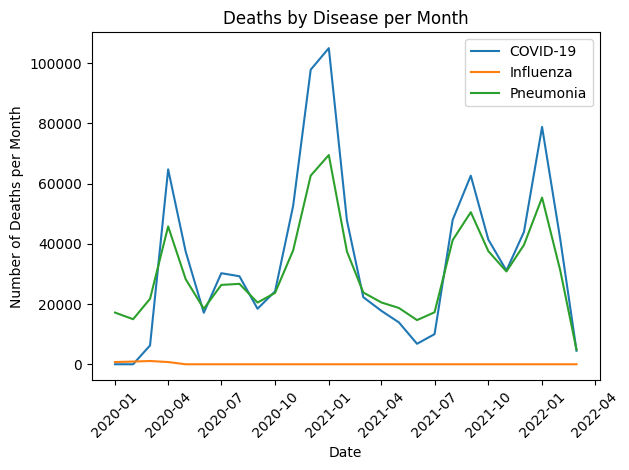

In [255]:
q2_df = sas_1[['Start Date','COVID-19 Deaths','Pneumonia Deaths','Influenza Deaths']].groupby('Start Date').sum().reset_index()
# Custom ticks for non-overlapping axis tick label
sns.lineplot(data= q2_df, 
             x ='Start Date',  
             y='COVID-19 Deaths', 
             label = "COVID-19")
sns.lineplot(data= q2_df, 
             x ='Start Date',  
             y='Influenza Deaths', 
             label = "Influenza")
sns.lineplot(data= q2_df, 
             x ='Start Date',  
             y='Pneumonia Deaths', 
             label = "Pneumonia")


plt.xticks(rotation=45)
plt.title('Deaths by Disease per Month')
plt.xlabel('Date')
plt.ylabel('Number of Deaths per Month')

plt.legend()
plt.tight_layout()
plt.show()

As observed in the graph, the number of COVID-19 deaths by month went through "periods" and peaks. The significant peak of COVID-19 deaths around early 2020 likely represents the initial global wave of the pandemic, where many regions were ill-prepared to handle the sudden surge in cases. The decrease in deaths during mid-2020 might reflect the period where lockdowns and strict measures were in place in many countries. The resurgence in late 2020 and early 2021 could be linked to the emergence of new variants, relaxed restrictions during holidays, or other socio-behavioral factors.This is likely heavily influenced by quarantine policies as well as the surface of new variants. Another important thing we can observe from the graph is that the number of deaths by pneumonia is closely related and has a positive relationship with the number of deaths by COVID-19. 

## Question 2
### Does the percentage of COVID-19 Deaths By Age Group Vary Over Time

In [41]:
q3_df = pd.pivot_table(data=sas_1, index='Start Date', columns='Age Group', values='COVID-19 Deaths', aggfunc='sum')
q3_df['total'] =  sas_1[['Start Date','COVID-19 Deaths']].groupby('Start Date').sum()
q3_df = q3_df.divide(q3_df['total'], axis='rows').drop(columns=['total'])

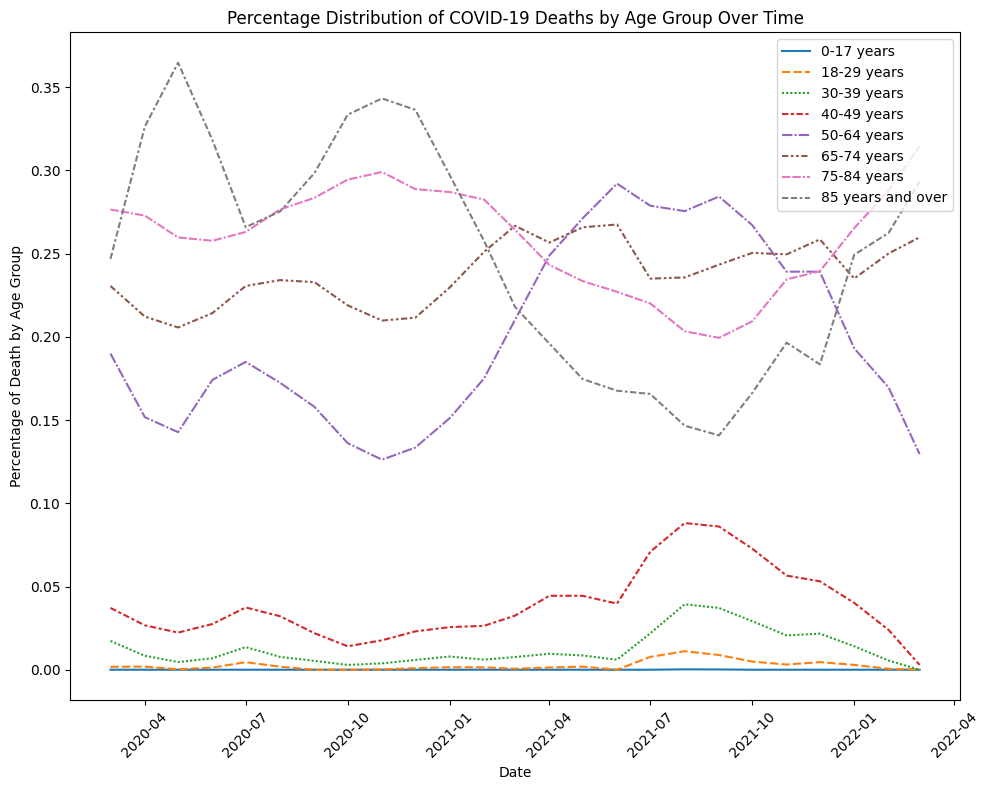

In [42]:
# Plot the graph using sns
plt.figure(figsize=(10,8))
sns.lineplot(data=q3_df)
plt.title("COVID-19 Death Percentages by Age Group over Time")
plt.ylabel("Percentage of Death by Age Group")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation=45)
plt.title("Percentage Distribution of COVID-19 Deaths by Age Group Over Time")
plt.tight_layout()
plt.show()

The graph shows that age groups older than 50 years have consistently higher percentages of COVID-19 related deaths compared to younger age groups. This aligns with general understanding and research that suggests older individuals are more susceptible to severe outcomes from COVID-19 due to age-related decline in immune function. Notably, the percentage of deaths for the age group "85 years and over" experienced a significant spike around 2020.01 to 2020.05. A potential explanation could be that during the early stages of the pandemic, many countries and regions were not adequately prepared, leading to outbreaks in vulnerable settings like nursing homes and long-term care facilities where a significant portion of the elderly population resides. Such outbreaks could disproportionately affect the eldest age group. While all older age groups have higher death percentages, there's a distinction between the 50-64 years group and the 65 and above groups. The latter groups (65 and above) seem to experience more pronounced peaks and troughs. This could be influenced by various factors, such as vaccine distribution (with older age groups being prioritized in many regions) and effectiveness of vaccines in elderly populations. While the death percentages for younger age groups are significantly lower, there are still noticeable trends, such as small spikes and fluctuations. This could be influenced by new variants, social behaviors, and vaccination rates among younger populations.

## Question 4 
### COVID-19 Risk vs Sex

In [276]:
q4_df = sas[['Start Date','COVID-19 Deaths','Sex']].pivot_table( values='COVID-19 Deaths' ,columns='Sex', index='Start Date', aggfunc=sum)
q4_df['total'] = q4_df['Male'] + q4_df['Female']
q4_df['% Male'] = q4_df['Male'] / q4_df['total']
q4_df['% Female'] = q4_df['Female'] / q4_df['total']
q4_df.reset_index(inplace=True)

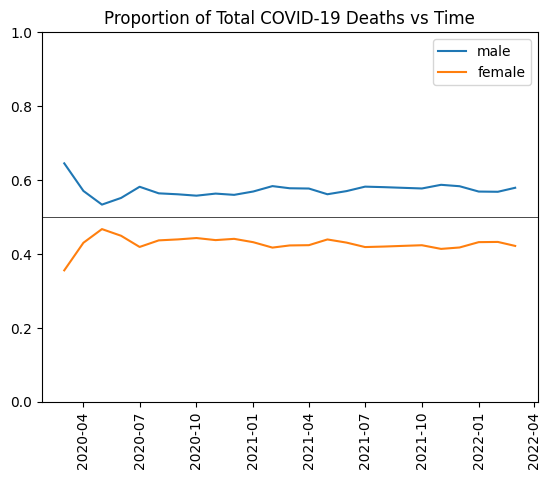

In [277]:
plt.plot(q4_df['Start Date'], q4_df['% Male'])
plt.plot(q4_df['Start Date'], q4_df["% Female"])
plt.axhline(.5, lw=0.5, c='black')
plt.legend(['male','female'])
plt.xticks(rotation=90)
plt.ylim((0,1))
plt.title("Proportion of Total COVID-19 Deaths vs Time");

Text(7.125000000000009, 0.5, 'Female Deaths')

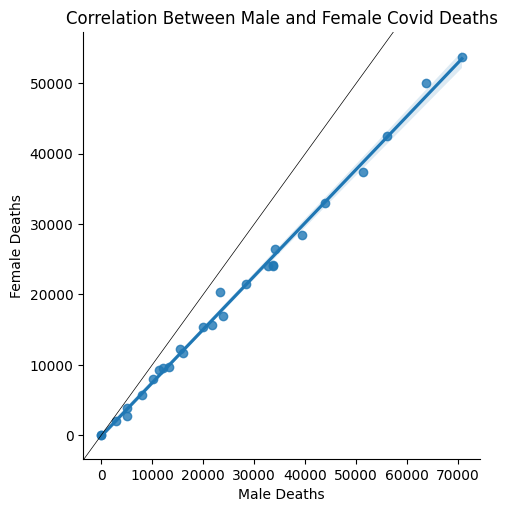

In [278]:
sns.lmplot(data=q4_df, x='Male', y='Female')
plt.axline((0,0), slope=1, lw=0.5, c='black')
plt.title("Correlation Between Male and Female Covid Deaths");
plt.xlabel('Male Deaths')
plt.ylabel('Female Deaths')

The number of deaths appear highly correlated while likely not having a correlation of 1. 

## Question 4
### What Factors are most important for predicting number of COVID-19 Deaths for a specific record

In [96]:
encoder = OneHotEncoder(drop=None, sparse_output=False)
start_dates_encoded = encoder.fit_transform(sas_1[['Start Date']])
states_encoded = encoder.fit_transform(sas_1[['State']])
sex_encoded = encoder.fit_transform(sas_1[['Sex']])
age_encoded = encoder.fit_transform(sas_1[['Age Group']])

In [213]:
def mse_for_features(X, y, label):
    for i in range(100):
        kf = KFold(n_splits=5, shuffle=True)

        mse = []
        for train_indices, test_indices in kf.split(X):
            X_train = X[train_indices]
            X_test = X[test_indices]
            y_train = y[train_indices]
            y_test = y[test_indices]

            linear_model = LinearRegression(fit_intercept=True, positive=True)
            linear_model.fit(X_train, y_train)

            # Make predictions
            y_pred = linear_model.predict(X_test)
            #import pdb; pdb.set_trace()
            # Calculate the mean squared error
            mse.append((label, mean_squared_error(y_test, y_pred)))
    return mse

In [99]:
y = sas_1[['COVID-19 Deaths']].fillna(value=0).values

In [100]:
X_all = np.concatenate(
    [
        start_dates_encoded,
        states_encoded,
        sex_encoded,
        age_encoded
    ],
               axis=1
               )

In [102]:
X_no_age = np.concatenate(
    [
        start_dates_encoded,
        states_encoded,
        sex_encoded,
    ],
               axis=1
               )

In [103]:
X_no_sex = np.concatenate(
    [
        start_dates_encoded,
        states_encoded,
        age_encoded
    ],
               axis=1
               )

In [104]:
X_no_states = np.concatenate(  
    [
        start_dates_encoded,
        sex_encoded,
        age_encoded
    ],
               axis=1
               )

In [105]:
X_no_time = np.concatenate(  
    [
        states_encoded,
        sex_encoded,
        age_encoded
    ],
               axis=1
               )

In [214]:
mse_list = []
mse_list += mse_for_features(X_all, y, 'All')

mse_list += mse_for_features(X_no_time, y, 'No Time')
mse_list += mse_for_features(X_no_states, y, 'No States')
mse_list += mse_for_features(X_no_age, y, 'No Age')
mse_list += mse_for_features(X_no_sex, y, 'No Sex')

mse_list += mse_for_features(start_dates_encoded, y, 'Time only')
mse_list += mse_for_features(states_encoded, y, 'States only')
mse_list += mse_for_features(age_encoded, y, 'Age only')
mse_list += mse_for_features(sex_encoded, y, 'Sex only')

mse_list += mse_for_features(np.zeros(y.shape), y, 'Constant Model')


In [215]:
LinReg_df = pd.DataFrame(mse_list, columns=['Features Used', 'Mean Squared Error'])
display(LinReg_df.head())

,Features Used,Mean Squared Error
0,All,10230.577068
1,All,8176.044551
2,All,13243.127271
3,All,10441.308352
4,All,10275.370198


(7500.0, 20000.0)

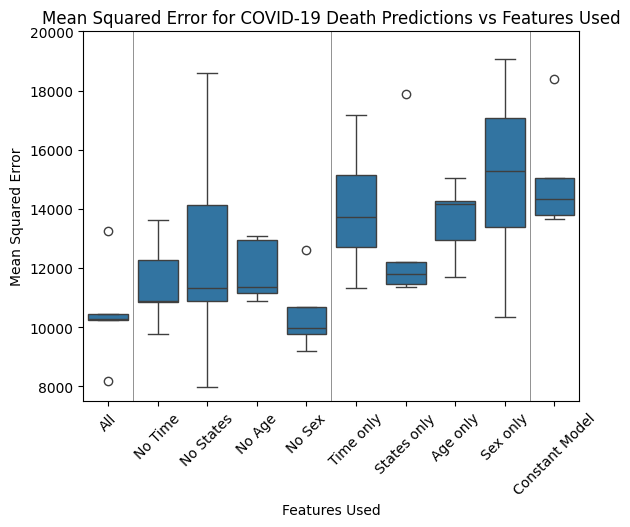

In [216]:
sns.boxplot(data=LinReg_df, x='Features Used', y='Mean Squared Error');
plt.xticks(rotation=45);
plt.axvline(0.5, lw=0.6, c='grey');
plt.axvline(4.5, lw=0.6, c='grey');
plt.axvline(8.5, lw=0.6, c='grey' );
plt.title('Mean Squared Error for COVID-19 Death Predictions vs Features Used')
plt.ylim([7500,20000])



These MSE results for the various features indicate the relative importance of different features: 
From Least to Most Important: 
Sex
Age
State
Time 
